In [1]:
!pip install plotly

# Projet Uber Pickups

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import date

import plotly.io as pio
pio.renderers.default = "iframe_connected"
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [2]:
april = pd.read_csv("apr14.csv")
may = pd.read_csv("may14.csv")
june = pd.read_csv("jun14.csv")
july = pd.read_csv("jul14.csv")
august = pd.read_csv("aug14.csv")
sept = pd.read_csv("sep14.csv")

#### Data preprocessings

In [37]:
df = pd.concat([april, may, june, july, august, sept], ignore_index=True).sample(50000, random_state=0).reset_index()

In [38]:
df["day_of_week"] = df['Date/Time'].astype({"Date/Time": 'datetime64[ns]'}).map(lambda x: x.weekday())
df["hour_of_day"] = df['Date/Time'].astype({"Date/Time": 'datetime64[ns]'}).map(lambda x: x.hour)
df.head()

,index,Date/Time,Lat,Lon,Base,day_of_week,hour_of_day
0,1596051,6/19/2014 9:09:00,40.7809,-73.9790,B02617,3,9
1,895170,5/9/2014 20:05:00,40.7673,-73.9564,B02617,4,20
2,1483071,6/29/2014 14:31:00,40.6721,-73.9646,B02598,6,14
3,2793242,8/12/2014 8:28:00,40.7751,-73.9567,B02598,1,8
4,3615099,9/10/2014 11:56:00,40.6271,-73.9437,B02598,2,11


#### Interactive map with plotly : uber pickups at different hours every day

In [6]:
fig0 = px.scatter_mapbox(df, 
                        lat="Lat", 
                        lon="Lon", 
                        color="day_of_week",
                        category_orders={"hour_of_day":[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5]}, 
                        size_max=15, 
                        animation_frame="hour_of_day",
                        zoom=10,
                        mapbox_style="carto-positron")
fig0.show()

#### Interactive map with plotly : peak hours according to the day of the week

In [7]:
fig0_2 = go.Figure()

fig0_2.add_trace(
    go.Histogram(
        x = df[df['day_of_week']==0]['hour_of_day']))

fig0_2.add_trace(
    go.Histogram(
        x = df[df['day_of_week']==1]['hour_of_day'],
        visible = False))

fig0_2.add_trace(
    go.Histogram(
        x = df[df['day_of_week']==2]['hour_of_day'],
        visible = False))

fig0_2.add_trace(
    go.Histogram(
        x = df[df['day_of_week']==3]['hour_of_day'],
        visible = False))

fig0_2.add_trace(
    go.Histogram(
        x = df[df['day_of_week']==4]['hour_of_day'],
        visible = False))

fig0_2.add_trace(
    go.Histogram(
        x = df[df['day_of_week']==5]['hour_of_day'],
        visible = False))

fig0_2.add_trace(
    go.Histogram(
        x = df[df['day_of_week']==6]['hour_of_day'],
        visible = False))


fig0_2.update_layout(
        title = go.layout.Title(text = "Peak hours according to the day of the week (dropdown menu)", x = 0.5))

fig0_2.update_layout(
    bargap=0.2,
    updatemenus = [go.layout.Updatemenu(
        active = 0,
        buttons = [
                    go.layout.updatemenu.Button(
                        label = "Monday",
                        method = "update",
                        args = [{"visible" : [True, False, False, False, False, False, False]}]),
                    go.layout.updatemenu.Button(
                            label = "Tuesday",
                            method = "update",
                            args = [{"visible" : [False, True, False, False, False, False, False]}]),
                    go.layout.updatemenu.Button(
                            label = "Wednesday",
                            method = "update",
                            args = [{"visible" : [False, False, True, False, False, False, False]}]),
                    go.layout.updatemenu.Button(
                            label = "Thursday",
                            method = "update",
                            args = [{"visible" : [False, False, False,True, False, False, False]}]),
                    go.layout.updatemenu.Button(
                            label = "Friday",
                            method = "update",
                            args = [{"visible" : [False, False, False,False, True, False, False]}]),
                    go.layout.updatemenu.Button(
                            label = "Saturday",
                            method = "update",
                            args = [{"visible" : [False, False, False,False, False, True, False]}]),
                    go.layout.updatemenu.Button(
                            label = "Sunday",
                            method = "update",
                            args = [{"visible" : [False, False, False,False, False, False, True]}]),
                    
                ]
    )]
)

### Try K-MEANS analysis on 2 features

In [14]:
X = df.loc[:,["hour_of_day","day_of_week"]]
sc = StandardScaler()
X = sc.fit_transform(X)

In [15]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=0)

<AxesSubplot:>

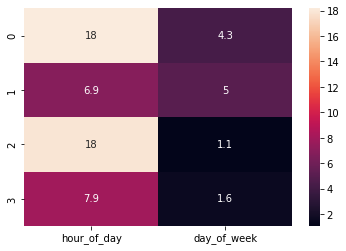

In [16]:
# Cluster centers coordinates
cluster_centers = sc.inverse_transform(kmeans.cluster_centers_)
# Let's get column names to facilita understanding 
labels = ["hour_of_day","day_of_week"]
# Create a heatmap 
sns.heatmap(pd.DataFrame(cluster_centers, columns=labels), annot=True)

#### Elbow assessment

In [8]:
wcss =  []
k = []
for i in range (1,11): 
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    k.append(i)
    
# Let's visualize using plotly
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)
fig_inertia= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1])
fig_inertia.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster")
fig_inertia.show(renderer="iframe") # if using workspace

#### Silhouette assessment

In [9]:
# Computer mean silhouette score
sil = []
k = []
## Careful, you need to start at i=2 as silhouette score cannot accept less than 2 labels 
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(X)
    sil.append(silhouette_score(X, kmeans.predict(X)))
    k.append(i)
    print("Silhouette score for K={} is {}".format(i, sil[-1]))

Silhouette score for K=2 is 0.36558254640701665
Silhouette score for K=3 is 0.4035333209447449
Silhouette score for K=4 is 0.40909388221059295
Silhouette score for K=5 is 0.37989218777815076
Silhouette score for K=6 is 0.3796174062633576
Silhouette score for K=7 is 0.3854947661909598
Silhouette score for K=8 is 0.3882434989908437
Silhouette score for K=9 is 0.38996922825097846
Silhouette score for K=10 is 0.37847357052457037


In [17]:
labels_Km = pd.Series(kmeans.labels_)
dim_clusters_Km = labels_Km.value_counts()
dim_clusters_Km

0    18866
2    12989
3    10705
1     7440
dtype: int64

In [18]:
df["cluster_Km"]=labels_Km.astype("str").tolist()

In [20]:
fig_Km = px.scatter_mapbox(df, 
                        lat="Lat", 
                        lon="Lon", 
                        color="cluster_Km",
                        animation_frame="day_of_week",
                        #category_orders={"cluster_2": ["-1","0","1","2","3","4","5","6","7","8","9","10","11", "12", "13"], 
                                         #"day_of_week":[0,1,2,3,4,5]}, 
                        size_max=25, 
                        zoom=10,
                        mapbox_style="carto-positron",
                        title = "Hot spots for Uber Pickups - KMeans Cluster")
fig_Km.show()

### Try K-MEANS analysis on 4 features

In [22]:
X_3 = df.loc[:,["Lat","Lon","day_of_week","hour_of_day"]]
sc = StandardScaler()
X_3 = sc.fit_transform(X_3)

In [24]:
kmeans2 = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_3)

KMeans(n_clusters=4, random_state=0)

<AxesSubplot:>

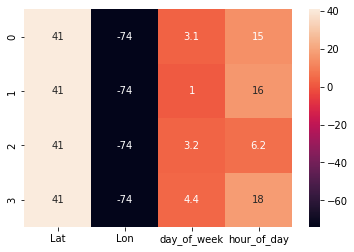

In [26]:
# Cluster centers coordinates
cluster_centers2 = sc.inverse_transform(kmeans.cluster_centers_)
# Let's get column names to facilita understanding 
labels2 = ["Lat","Lon","day_of_week","hour_of_day"]
# Create a heatmap 
sns.heatmap(pd.DataFrame(cluster_centers, columns=labels), annot=True)

In [27]:
labels_Km2 = pd.Series(kmeans.labels_)
dim_clusters_Km2 = labels_Km.value_counts()
dim_clusters_Km2

0    18866
2    12989
3    10705
1     7440
dtype: int64

In [28]:
df["cluster_Km2"]=labels_Km2.astype("str").tolist()

In [30]:
fig_Km2 = px.scatter_mapbox(df, 
                        lat="Lat", 
                        lon="Lon", 
                        color="cluster_Km2",
                        animation_frame="day_of_week",
                        #category_orders={"cluster_2": ["-1","0","1","2","3","4","5","6","7","8","9","10","11", "12", "13"], 
                                         #"day_of_week":[0,1,2,3,4,5]}, 
                        size_max=25, 
                        zoom=10,
                        mapbox_style="carto-positron",
                        title = "Hot spots for Uber Pickups - KMeans Cluster 2")
fig_Km2.show()

#### Conclusion on K-Means
- K-means is not really satisfying, let's try with DBScan

### Try DBScan

#### DBScan with 2 features (geo coordinates)

In [39]:
X_2 = df.loc[:,["Lat","Lon"]]
sc = StandardScaler()
X_2 = sc.fit_transform(X_2)
X_2[:5]

array([[ 1.02279013, -0.11058571],
       [ 0.68695988,  0.28474359],
       [-1.66385184,  0.14130552],
       [ 0.87956841,  0.27949585],
       [-2.77505487,  0.50689766]])

In [55]:
db = DBSCAN(eps=0.11, min_samples=45, metric="manhattan", algorithm="brute") 
db.fit(X_2)

DBSCAN(algorithm='brute', eps=0.11, metric='manhattan', min_samples=45)

In [56]:
np.unique(db.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [57]:
labels = pd.Series(db.labels_)
dim_clusters = labels.value_counts()
dim_clusters

 0     37391
-1      3916
 1      2960
 2      2366
 5      1161
 3       999
 6       318
 7       315
 9       116
 4       103
 10       85
 8        80
 11       70
 12       61
 13       59
dtype: int64

In [58]:
df["cluster"]=labels.astype("str").tolist()

In [59]:
fig1 = px.scatter_mapbox(df, 
                        lat="Lat", 
                        lon="Lon", 
                        color="cluster",
                        animation_frame="day_of_week",
                        category_orders={"cluster": ["-1","0","1","2","3","4","5","6","7","8","9","10","11", "12", "13"], 
                                         "day_of_week":[0,1,2,3,4,5]}, 
                        size_max=25, 
                        zoom=10,
                        mapbox_style="carto-positron",
                        title = "Hot spots for Uber Pickups according to days of the week")
fig1.show()

#### DBScan with 4 features (geo coordinates + hour + day)

In [72]:
X_3 = df.loc[:,["Lat","Lon","day_of_week","hour_of_day"]]
sc = StandardScaler()
X_3 = sc.fit_transform(X_3)
X_3[:5]

array([[ 1.02279013, -0.11058571,  0.0164811 , -0.86409893],
       [ 0.68695988,  0.28474359,  0.54847275,  0.97605383],
       [-1.66385184,  0.14130552,  1.61245604, -0.02766586],
       [ 0.87956841,  0.27949585, -1.04750219, -1.03138555],
       [-2.77505487,  0.50689766, -0.51551054, -0.5295257 ]])

In [87]:
db_2 = DBSCAN(eps=0.5, min_samples=50, metric="manhattan", algorithm="brute") 
db_2.fit(X_3)

DBSCAN(algorithm='brute', metric='manhattan', min_samples=50)

In [88]:
np.unique(db_2.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21])

In [89]:
labels_2 = pd.Series(db_2.labels_)
dim_clusters_2 = labels_2.value_counts()
dim_clusters_2

-1     9738
 0     6725
 1     6534
 3     6295
 2     5798
 6     4870
 7     4448
 4     2882
 5      760
 10     623
 8      192
 12     162
 11     136
 17     128
 14     127
 19      87
 13      86
 16      83
 18      74
 9       72
 15      65
 21      61
 20      54
dtype: int64

In [90]:
df["cluster_2"]=labels_2.astype("str").tolist()

In [92]:
fig2 = px.scatter_mapbox(df, 
                        lat="Lat", 
                        lon="Lon", 
                        color="cluster_2",
                        animation_frame="day_of_week",
                        category_orders={"cluster_2": ["-1","0","1","2","3","4","5","6","7","8","9","10","11", "12", "13"], 
                                         "day_of_week":[0,1,2,3,4,5]}, 
                        size_max=25, 
                        zoom=10,
                        mapbox_style="carto-positron",
                        title = "Hot spots for Uber Pickups - 4 dimensions")
fig2.show()